파이토치 사용법
1. 데이터셋 작성
2. 데이터로더 작성
3. 모델 작성
4. 손실함수, 최적화 정의
5. 학습 및 검증

Glancing Pytorch Framework codes

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transfroms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device + " is available")

learning_rate = 0.001
batch_size = 100
num_classes = 10
epochs = 5

# MNIST 데이터셋 로드
train_set = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=True,
    download=True,
    transform=transfroms.Compose([
        transfroms.ToTensor()  # 데이터를 0에서 255까지 있는 값을 0에서 1사이 값으로 변환
    ])
)
test_set = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=False,
    download=True,
    transform=transfroms.Compose([
        transfroms.ToTensor()  # 데이터를 0에서 255까지 있는 값을 0에서 1사이 값으로 변환
    ])
)

# train_loader, test_loader 생성
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# input size를 알기 위해서
examples = enumerate(train_set)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


class ConvNet(nn.Module):
    def __init__(self):  # layer 정의
        super(ConvNet, self).__init__()

        # input size = 28x28
        self.conv1 = nn.Conv2d(1, 10,
                               kernel_size=5)  # input channel = 1, filter = 10, kernel size = 5, zero padding = 0, stribe = 1
        # ((W-K+2P)/S)+1 공식으로 인해 ((28-5+0)/1)+1=24 -> 24x24로 변환
        # maxpooling하면 12x12

        self.conv2 = nn.Conv2d(10, 20,
                               kernel_size=5)  # input channel = 1, filter = 10, kernel size = 5, zero padding = 0, stribe = 1
        # ((12-5+0)/1)+1=8 -> 8x8로 변환
        # maxpooling하면 4x4

        self.drop2D = nn.Dropout2d(p=0.25, inplace=False)  # 랜덤하게 뉴런을 종료해서 학습을 방해해 학습이 학습용 데이터에 치우치는 현상을 막기 위해 사용
        self.mp = nn.MaxPool2d(2)  # 오버피팅을 방지하고, 연산에 들어가는 자원을 줄이기 위해 maxpolling
        self.fc1 = nn.Linear(320, 100)  # 4x4x20 vector로 flat한 것을 100개의 출력으로 변경
        self.fc2 = nn.Linear(100, 10)  # 100개의 출력을 10개의 출력으로 변경

    def forward(self, x):
        x = F.relu(self.mp(self.conv1(x)))  # convolution layer 1번에 relu를 씌우고 maxpool, 결과값은 12x12x10
        x = F.relu(self.mp(self.conv2(x)))  # convolution layer 2번에 relu를 씌우고 maxpool, 결과값은 4x4x20
        x = self.drop2D(x)
        x = x.view(x.size(0), -1)  # flat
        x = self.fc1(x)  # fc1 레이어에 삽입
        x = self.fc2(x)  # fc2 레이어에 삽입
        return F.log_softmax(x)  # fully-connected layer에 넣고 logsoftmax 적용


model = ConvNet().to(device)  # CNN instance 생성
# Cost Function과 Optimizer 선택
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):  # epochs수만큼 반복
    avg_cost = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()  # 모든 model의 gradient 값을 0으로 설정
        hypothesis = model(data)  # 모델을 forward pass해 결과값 저장
        cost = criterion(hypothesis, target)  # output과 target의 loss 계산
        cost.backward()  # backward 함수를 호출해 gradient 계산
        optimizer.step()  # 모델의 학습 파라미터 갱신
        avg_cost += cost / len(train_loader)  # loss 값을 변수에 누적하고 train_loader의 개수로 나눔 = 평균
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

# test
model.eval()  # evaluate mode로 전환 dropout 이나 batch_normalization 해제
with torch.no_grad():  # grad 해제
    correct = 0
    total = 0

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        out = model(data)
        preds = torch.max(out.data, 1)[1]  # 출력이 분류 각각에 대한 값으로 나타나기 때문에, 가장 높은 값을 갖는 인덱스를 추출
        total += len(target)  # 전체 클래스 개수
        correct += (preds == target).sum().item()  # 예측값과 실제값이 같은지 비교

    print('Test Accuracy: ', 100. * correct / total, '%')

cpu is available


C:\Users\pitbull\AppData\Local\Temp\ipykernel_12760\2697207695.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)  # fully-connected layer에 넣고 logsoftmax 적용


[Epoch:    1] cost = 0.31730783
[Epoch:    2] cost = 0.114742726
[Epoch:    3] cost = 0.0868237242
[Epoch:    4] cost = 0.0750293583
[Epoch:    5] cost = 0.0662271008
Test Accuracy:  98.57 %


1. 데이터셋 작성
- Fashion MNIST Data
(Modified National Institute Standards and Technology)
0~255 사이의 값을 가진 28x28 흑백 이미지와 10개의 클래스로 구성된 운동화,셔츠와 같은 작은 이미지들의 모음
- train : True (train 모델 사용), False (test 모델 사용)
- ToTensor() : 이미지를 torch.tensor 로 변환하고 이를 통해 이미지 데이터를 텐서형태로 사용 가능


- Custom Dataset 만들기 구조

In [11]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class MyCustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [12]:
import torch
from torch.utils.data import DataLoader

# 임의의 데이터와 타깃을 생성합니다.
data = torch.randn(100, 3, 64, 64)  # 100개의 3x64x64 크기의 이미지를 가정합니다.
targets = torch.randint(0, 2, (100,))  # 100개의 이진 라벨을 가정합니다.
print(targets)
print(targets.shape)
# 사용자 정의 데이터셋을 생성합니다.
dataset = MyCustomDataset(data, targets)

# 데이터 로더를 생성합니다.
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# 데이터 로더를 통해 데이터를 순회합니다.
for i, (data_batch, target_batch) in enumerate(data_loader):
    print(f"Batch {i + 1}")
    print("Data:", data_batch)
    print("Target:", target_batch)
    break

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1])
torch.Size([100])
Batch 1
Data: tensor([[[[-1.0807e+00, -6.4392e-02, -2.0726e-01,  ..., -9.8101e-01,
            1.0331e+00, -9.6834e-02],
          [ 3.1088e+00,  1.6202e+00, -8.3684e-01,  ...,  2.5355e-01,
           -8.7337e-01, -5.5778e-01],
          [-1.0154e+00, -1.4169e+00,  2.0523e-01,  ..., -4.8804e-01,
           -7.6627e-01,  5.3233e-01],
          ...,
          [ 3.1470e-01, -7.2314e-01,  2.2725e-01,  ..., -5.4832e-02,
            1.7134e-01, -2.6390e-01],
          [-5.0363e-01,  3.5534e-01, -1.2255e+00,  ..., -6.7886e-01,
           -9.7169e-02,  1.9610e-01],
          [-7.1865e-01,  3.7672e-01,  8.6307e-01,  ...,  5.8079e-01,
        

- 학습하고자 하는 데이터 확인

In [13]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(root="data", train=True,
                                      download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False,
                                  download=True, transform=ToTensor())
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
    }
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

2. 데이터로더 작성
- batch_size : 한번에 처리할 데이터 양
- shuffle : 무작위로 가져온다

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

- 데이터로더 시각화
- 데이터 형태 : image, label

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


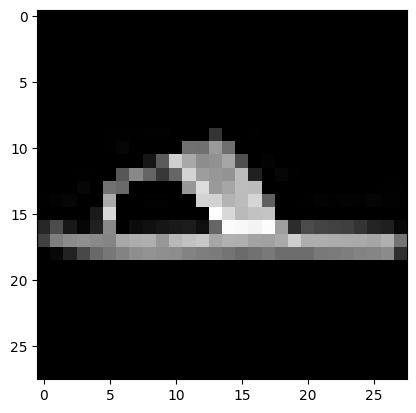

Label: 5


In [15]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

데이터 변형 (transform)
- ToTensor() : 이미지를 torch.tensor 로 변환하고 이를 통해 이미지 데이터를 텐서형태로 사용 가능
- torch.zeros(10, dtype=torch.float) : 0으로 구성된 10개의 원소를 가지는 벡터
- scatter_ : 해당하는 index에 1을 할당하여 one-hot 인코딩으로 변환


In [16]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(root="data", train=True, download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


In [21]:
from torchvision.transforms import *
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 50% 확률로 이미지를 수평으로 뒤집음
    transforms.RandomRotation(10),      # 최대 10도로 랜덤하게 회전
    transforms.ToTensor(),              # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5,), (0.5,)),  # 텐서를 정규화 (예시는 grayscale 이미지를 위한 값)
])

# 연습문제
1. MNIST 데이터셋을 train 데이터로 사용할 수 있게 이미지를 텐서형태로 변환하여 생성하십시오.
2. 생성한 train 데이터를 가지고 dataloader를 생성하십시오.
3. Feature와 label로 구성된 데이터의 첫번째 배치 size를 출력하십시오.



In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# 1번 문제
td = datasets.FashionMNIST(root="data", train=True,
                                      download=True, transform=ToTensor())

# 2번 문제
tl = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True)

# 3번 문제
images, labels = next(iter(tl))
print(f'이미지 크기: {images.size()}')
print(f'라벨 크기: {labels.size()}')

이미지 크기: torch.Size([32, 1, 28, 28])
라벨 크기: torch.Size([32])


3. 모델 작성

- 사용가능한 device 확인

In [1]:
import os
import torch
from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


- 신경망 모델을 nn.Module 의 하위클래스로 정의
- __init__ 에서 신경망 계층들을 초기화
- nn.Module 을 상속받는 모든 클래스는 forward 메소드에 입력 데이터에 대한 연산으로 구현


In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

- 모델 instance

In [3]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


- 모델 테스트
1. 모델 입력값은 2차원 텐서로 반환
2. 2차원 텐서의 dim=0은 각 분류(class)에 대한 원시(raw) 예측값 10개가, dim=1에는 각 출력의 개별 값들이 해당
3. 예측값은 nn.Softmax 모듈을 통해 확률 표시


In [5]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
print(logits)
pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

tensor([[ 0.0456,  0.0142, -0.0137,  0.0004, -0.1298,  0.0148, -0.0162,  0.0684,
         -0.1174, -0.0545]], grad_fn=<AddmmBackward0>)
tensor([[0.1065, 0.1032, 0.1003, 0.1018, 0.0893, 0.1032, 0.1001, 0.1089, 0.0904,
         0.0963]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([7])


- Batch에 따른 사이즈 확인
1. 28x28 크기의 이미지 3개로 구성된 미니배치를 통해 구현한 신경망을 통과하는 경우

In [43]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [44]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


- Model layer에 따른 output size 확인
1. nn.Linear() : 입력 크기가 28x28인 1차원 벡터를 받아서 20개의 출력을 생성
2. 가중치(weight)와 편향(bias)을 사용하여 입력에 선형 변환(linear transformation)을 적용하는 모듈


In [45]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


- 활성화 layer에 따른 output 확인
1. 비선형 활성화 함수 relu 적용 전과 후

In [46]:
print(f"Before ReLU: {hidden1[0]}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1[0]}")

Before ReLU: tensor([-0.1856, -0.3039,  0.1605, -0.3217,  0.0572, -0.1534,  0.5380, -0.1597,
         0.1057, -0.0866, -0.0062, -0.7441, -0.2745,  0.1884,  0.0614,  0.1814,
        -0.4218,  0.0415, -0.5500,  0.6010], grad_fn=<SelectBackward0>)


After ReLU: tensor([0.0000, 0.0000, 0.1605, 0.0000, 0.0572, 0.0000, 0.5380, 0.0000, 0.1057,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1884, 0.0614, 0.1814, 0.0000, 0.0415,
        0.0000, 0.6010], grad_fn=<SelectBackward0>)


In [11]:
import torch
import torch.nn as nn
torch.manual_seed(1)
# 선형 활성화 함수를 사용하는 신경망 모델 정의
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # 입력 차원과 출력 차원이 1인 선형 계층

    def forward(self, x):
        return self.linear(x)

# 모델 인스턴스 생성
model = LinearModel()

# 입력 데이터 생성
x = torch.tensor([[1.0], [-2.0], [3.0]])

# 모델에 입력 전달
output = model(x)
print(output)

tensor([[ 0.0739],
        [-1.4719],
        [ 1.1044]], grad_fn=<AddmmBackward0>)


In [12]:
import torch
import torch.nn as nn
torch.manual_seed(1)
# ReLU 활성화 함수를 사용하는 신경망 모델 정의
class ReLUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # 입력 차원과 출력 차원이 1인 선형 계층
        self.relu = nn.ReLU()  # ReLU 활성화 함수

    def forward(self, x):
        x = self.linear(x)
        return self.relu(x)

# 모델 인스턴스 생성
model = ReLUModel()

# 입력 데이터 생성
x = torch.tensor([[1.0], [-2.0], [3.0]])

# 모델에 입력 전달
output = model(x)
print(output)


tensor([[0.0739],
        [0.0000],
        [1.1044]], grad_fn=<ReluBackward0>)


- nn.Sequential() : 순서를 갖는 모듈의 컨테이너
데이터는 정의된 것과 같은 순서, 즉 순차적으로 모든 모듈들을 통해 전달
- nn.Softmax : logits는 모델의 각 분류(class)에 대한 예측 확률을 나타내도록 [0, 1] 범위로 비례하여 조정

In [50]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
print(pred_probab)

tensor([[0.1267, 0.0892, 0.1000, 0.0977, 0.1092, 0.0965, 0.0790, 0.1133, 0.0980,
         0.0902],
        [0.1244, 0.0905, 0.0919, 0.1116, 0.0919, 0.0940, 0.0834, 0.1269, 0.0931,
         0.0922],
        [0.1334, 0.0838, 0.0973, 0.0962, 0.0947, 0.1076, 0.0761, 0.1273, 0.0989,
         0.0846]], grad_fn=<SoftmaxBackward0>)


# 연습문제
1. MNIST 데이터셋을 학습하고 예측할 ConvNet() 클래스를 만드십시오.
2. feature의 특징을 찾을 conv층으로 각각 입력채널=1, 출력채널=16, kernel_szie=3, stride=1, padding=1 와 입력채널=16, 출력채널=32, 그리고 공통된 kernel_size와 stride, padding을 가지는 2개의 conv층과 relu, maxpool2d, kernel_size=2, stride=2 가지는 모델을 Sequential 하게 구성하십시오.
3. classifier 분류를 위한 flatten, Linear: 입력채널=7x7x32, 출력채널=128 과 relu, Linear: 입력채널=128, 출력채널=10을 구성하십시오.

In [39]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*32, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
print(ConvNet())

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


- MSE 손실 함수 예제

In [65]:
import torch
import torch.nn as nn
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
print(output)

tensor(4.0053, grad_fn=<MseLossBackward0>)


- Cross entropy 손실 함수 예제

In [66]:
import torch
import torch.nn as nn
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(output)

tensor(2.5231, grad_fn=<NllLossBackward0>)


- 자동 미분 예제

In [23]:
import torch

# 텐서 생성과 requires_grad=True 설정
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

# 연산 수행
z = x**2 + y**3

# z를 통해 역전파 수행
z.backward()

# x와 y의 그래디언트 출력
print("dz/dx:", x.grad)  # 출력: dz/dx: tensor(4.)
print("dz/dy:", y.grad)  # 출력: dz/dy: tensor(27.)


dz/dx: tensor(4.)
dz/dy: tensor(27.)


In [41]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")
loss.backward()
print(w.grad)
print(b.grad)

Gradient function for z = <AddBackward0 object at 0x000001949CD38C10>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001949CD38E20>
tensor([[0.0314, 0.3192, 0.0207],
        [0.0314, 0.3192, 0.0207],
        [0.0314, 0.3192, 0.0207],
        [0.0314, 0.3192, 0.0207],
        [0.0314, 0.3192, 0.0207]])
tensor([0.0314, 0.3192, 0.0207])


하이퍼 파라미터 정의
- 에폭(epoch) 수 - 데이터셋을 반복하는 횟수
- 배치 크기(batch size) - 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수
- 학습률(learning rate) - 각 배치/에폭에서 모델의 매개변수를 조절하는 비율.


In [30]:
learning_rate = 0.001
batch_size = 64
epochs = 5

4. 손실함수 & 최적화
- 손실함수
- 옵티마이저 최적화

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

중간 Code 작성

In [67]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

learning_rate = 0.001
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

5. 학습 및 검증
- 학습 loop 생성
- 검증 loop 생성

In [68]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

5. 학습 및 검증
- epcoh : 10번

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298093  [   64/60000]
loss: 2.283681  [ 6464/60000]
loss: 2.270428  [12864/60000]
loss: 2.276877  [19264/60000]
loss: 2.244940  [25664/60000]
loss: 2.225164  [32064/60000]
loss: 2.229999  [38464/60000]
loss: 2.190429  [44864/60000]
loss: 2.184989  [51264/60000]
loss: 2.154645  [57664/60000]
Test Error: 
 Accuracy: 50.1%, Avg loss: 2.151363 

Epoch 2
-------------------------------
loss: 2.161091  [   64/60000]
loss: 2.149681  [ 6464/60000]
loss: 2.092606  [12864/60000]
loss: 2.114735  [19264/60000]
loss: 2.052111  [25664/60000]
loss: 1.996265  [32064/60000]
loss: 2.022427  [38464/60000]
loss: 1.939349  [44864/60000]
loss: 1.937634  [51264/60000]
loss: 1.854589  [57664/60000]
Test Error: 
 Accuracy: 58.5%, Avg loss: 1.866555 

Epoch 3
-------------------------------
loss: 1.903443  [   64/60000]
loss: 1.870706  [ 6464/60000]
loss: 1.751920  [12864/60000]
loss: 1.794262  [19264/60000]
loss: 1.677605  [25664/60000]
loss: 1.632181  [32064/600

- 모델 저장 및 모델 로드

In [70]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [71]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

5. 학습 및 검증
- 시각화
- model.eval(): 딥러닝 모델을 평가 모드로 설정하여 모델 내부에서 드롭아웃과 같은 학습 중에만 적용되는 연산들을 비활성화 시킴
- torch.no_grad(): 이후의 연산들은 그라디언트 계산을 필요로 하지 않으므로, 연산이 자동으로 기록되지 않도록 설정
- test_data[5][0],[5][1]: 테스트 데이터셋에서 인덱스 5에 해당하는 이미지와 레이블을 사용


In [1]:
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot",
    ]

model.eval()
x, y = test_data[5][0], test_data[5][1] # test_data[][image], test_data[][label]

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]

    plt.imshow(x.squeeze(), cmap='gray')
    plt.title(actual)
    plt.axis('off')
    plt.show()

    print(f'Predicted: "{predicted}", Actual: "{actual}"')


NameError: name 'model' is not defined

# 연습 문제
1. 만들어둔 ConvNet 모델을 생성하십시오.
2. 손실함수 (CrossEntropyLoss), 옵티마이저 (Adam), learning_late (0.001)로 생성하십시오.
3. 역전파,순전파,손실 계산을 통해 학습 단을 생성하십시오. (epoch=10)
4. 예측을 통해 정확도 평가를 진행하십시오.

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


# 데이터 로딩 및 전처리
train_data = MNIST(root='data/', train=True, transform=ToTensor(), download=True)
test_data = MNIST(root='data/', train=False, transform=ToTensor())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# 모델 인스턴스 생성

# 손실 함수와 옵티마이저 정의

# 학습

# 예측

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 24134054.32it/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 4741308.62it/s]

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 9499615.94it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



# 연습문제 코드

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# 데이터 로딩 및 전처리
train_data = MNIST(root='data/', train=True, transform=ToTensor(), download=True)
test_data = MNIST(root='data/', train=False, transform=ToTensor())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# 모델 인스턴스 생성
model = ConvNet()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward 연산
        outputs = model(data)

        # 손실 계산
        loss = criterion(outputs, targets)

        # Backward 연산 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 예측
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"테스트 데이터에 대한 정확도: {accuracy * 100:.2f}%")

테스트 데이터에 대한 정확도: 99.01%
